# **IMPORT** **LIBRARY**

In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import re
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import MinMaxScaler
import nltk
from datetime import datetime
import pickle
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from scipy.sparse import hstack, csr_matrix

# **LOAD DATASET**

In [33]:
try:
    nltk.data.find('corpora/stopwords')
except LookupError:
    nltk.download('stopwords')

warnings.filterwarnings('ignore')

df = pd.read_csv('./dataset_anime/anime-dataset-2023.csv')
ratings = pd.read_csv('./dataset_anime/users-score-2023.csv')

print(f"anime dataset: {df.shape} ")
print(f"user score dataset: {ratings.shape}")

anime dataset: (24905, 24) 
user score dataset: (24325191, 5)


# **EDA (EXPLORE DATA ANALYSIS)**

In [34]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24325191 entries, 0 to 24325190
Data columns (total 5 columns):
 #   Column       Dtype 
---  ------       ----- 
 0   user_id      int64 
 1   Username     object
 2   anime_id     int64 
 3   Anime Title  object
 4   rating       int64 
dtypes: int64(3), object(2)
memory usage: 927.9+ MB


In [35]:
missing_values = ratings.isnull().sum().sort_values(ascending=False)
missing_values.head()

Username       232
user_id          0
anime_id         0
Anime Title      0
rating           0
dtype: int64

In [36]:
ratings.drop('Username', axis=1, inplace=True)

In [37]:
ratings.duplicated().sum()

0

In [38]:
df.head()

,anime_id,Name,English name,Other name,Score,Genres,Synopsis,Type,Episodes,Aired,...,Studios,Source,Duration,Rating,Rank,Popularity,Favorites,Scored By,Members,Image URL
0,1,Cowboy Bebop,Cowboy Bebop,カウボーイビバップ,8.75,"Action, Award Winning, Sci-Fi","Crime is timeless. By the year 2071, humanity ...",TV,26.0,"Apr 3, 1998 to Apr 24, 1999",...,Sunrise,Original,24 min per ep,R - 17+ (violence & profanity),41.0,43,78525,914193.0,1771505,https://cdn.myanimelist.net/images/anime/4/196...
1,5,Cowboy Bebop: Tengoku no Tobira,Cowboy Bebop: The Movie,カウボーイビバップ 天国の扉,8.38,"Action, Sci-Fi","Another day, another bounty—such is the life o...",Movie,1.0,"Sep 1, 2001",...,Bones,Original,1 hr 55 min,R - 17+ (violence & profanity),189.0,602,1448,206248.0,360978,https://cdn.myanimelist.net/images/anime/1439/...
2,6,Trigun,Trigun,トライガン,8.22,"Action, Adventure, Sci-Fi","Vash the Stampede is the man with a $$60,000,0...",TV,26.0,"Apr 1, 1998 to Sep 30, 1998",...,Madhouse,Manga,24 min per ep,PG-13 - Teens 13 or older,328.0,246,15035,356739.0,727252,https://cdn.myanimelist.net/images/anime/7/203...
3,7,Witch Hunter Robin,Witch Hunter Robin,Witch Hunter ROBIN (ウイッチハンターロビン),7.25,"Action, Drama, Mystery, Supernatural",Robin Sena is a powerful craft user drafted in...,TV,26.0,"Jul 3, 2002 to Dec 25, 2002",...,Sunrise,Original,25 min per ep,PG-13 - Teens 13 or older,2764.0,1795,613,42829.0,111931,https://cdn.myanimelist.net/images/anime/10/19...
4,8,Bouken Ou Beet,Beet the Vandel Buster,冒険王ビィト,6.94,"Adventure, Fantasy, Supernatural",It is the dark century and the people are suff...,TV,52.0,"Sep 30, 2004 to Sep 29, 2005",...,Toei Animation,Manga,23 min per ep,PG - Children,4240.0,5126,14,6413.0,15001,https://cdn.myanimelist.net/images/anime/7/215...


In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24905 entries, 0 to 24904
Data columns (total 24 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   anime_id      24905 non-null  int64 
 1   Name          24905 non-null  object
 2   English name  24905 non-null  object
 3   Other name    24905 non-null  object
 4   Score         24905 non-null  object
 5   Genres        24905 non-null  object
 6   Synopsis      24905 non-null  object
 7   Type          24905 non-null  object
 8   Episodes      24905 non-null  object
 9   Aired         24905 non-null  object
 10  Premiered     24905 non-null  object
 11  Status        24905 non-null  object
 12  Producers     24905 non-null  object
 13  Licensors     24905 non-null  object
 14  Studios       24905 non-null  object
 15  Source        24905 non-null  object
 16  Duration      24905 non-null  object
 17  Rating        24905 non-null  object
 18  Rank          24905 non-null  object
 19  Popu

In [40]:
missing_values = df.isnull().sum().sort_values(ascending=False)
missing_values.head()

anime_id     0
Name         0
Members      0
Scored By    0
Favorites    0
dtype: int64

Cek unknown data

In [41]:
for col in df.columns:
    if df[col].dtype == object:
        unknown_mask = df[col] == 'UNKNOWN'
        if unknown_mask.any():
            print(f"Column '{col}' has {unknown_mask.sum()} 'UNKNOWN' values")

Column 'English name' has 14577 'UNKNOWN' values
Column 'Other name' has 128 'UNKNOWN' values
Column 'Score' has 9213 'UNKNOWN' values
Column 'Genres' has 4929 'UNKNOWN' values
Column 'Type' has 74 'UNKNOWN' values
Column 'Episodes' has 611 'UNKNOWN' values
Column 'Premiered' has 19399 'UNKNOWN' values
Column 'Producers' has 13350 'UNKNOWN' values
Column 'Licensors' has 20170 'UNKNOWN' values
Column 'Studios' has 10526 'UNKNOWN' values
Column 'Rating' has 669 'UNKNOWN' values
Column 'Rank' has 4612 'UNKNOWN' values
Column 'Scored By' has 9213 'UNKNOWN' values


Convert Episodes to numeric

In [42]:
numeric_cols = ['Favorites', 'Popularity', 'Members', 'Scored By', 'Score', 'Episodes']
for col in numeric_cols:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col].replace('UNKNOWN', np.nan), errors='coerce')

Fill the missing Values

In [43]:
median_episodes = df.groupby('Type')['Episodes'].transform('median')
df['Episodes'].fillna(median_episodes, inplace=True)
df['Episodes'].fillna(df['Episodes'].median(), inplace=True)

 Drop rows with missing scores

In [44]:
# df.dropna(subset=['Score', "Scored By"], inplace=True)
# df = df[(df['Genres'] != 'UNKNOWN') & (df['Synopsis'] != 'UNKNOWN') & (df['Type'] != "UNKNOWN")]

print(f"Dataset shape after handling critical missing values: {df.shape}")

Dataset shape after handling critical missing values: (24905, 24)


In [45]:
df.replace('UNKNOWN', pd.NA, inplace=True)
df['Studios'].fillna('No data', inplace=True)
df['Producers'].fillna('No data', inplace=True)
df['Rating'].fillna("NO data", inplace = True)

Make sure English name is filled if available, If English name is empty but Name exists, use Name

In [46]:
if "English name" in df.columns:
    mask = df["English name"].isna() | (df["English name"] == "UNKNOWN")
    df.loc[mask, "English name"] = df.loc[mask, "Name"]

In [47]:
# Check again Unknown Value
for col in df.columns:
    if df[col].dtype == object:  # Only check object columns
        unknown_mask = df[col] == 'UNKNOWN'
        if unknown_mask.any():
            print(f"Column '{col}' has {unknown_mask.sum()} 'UNKNOWN' values")

In [48]:
print(f"Dataset shape after handling critical missing values: {df.shape}")

Dataset shape after handling critical missing values: (24905, 24)


In [49]:
missing_percentage = df.isnull().mean().sort_values(ascending=False) * 100
missing_percentage.head()

Licensors    80.987753
Premiered    77.891990
Score        36.992572
Scored By    36.992572
Genres       19.791207
dtype: float64

Drop the 4 columns, because not important and also have missing values more than 50%

In [50]:
drop_cols = ['Premiered', 'Licensors', 'Rank', 'Other name']
df.drop(drop_cols, axis=1, inplace=True)

In [51]:
# Basic EDA
print("\n--- Basic Exploratory Data Analysis ---")
df.describe()


--- Basic Exploratory Data Analysis ---


,anime_id,Score,Episodes,Popularity,Favorites,Scored By,Members
count,24905.000000,15692.000000,24905.000000,24905.000000,24905.000000,1.569200e+04,2.490500e+04
mean,29776.709014,6.380890,14.935234,12265.388356,432.595222,2.997438e+04,3.710496e+04
std,17976.076290,0.928696,48.005927,7187.428393,4353.181647,1.169348e+05,1.568252e+05
min,1.000000,1.850000,1.000000,0.000000,0.000000,1.000000e+02,0.000000e+00
25%,10507.000000,5.730000,1.000000,6040.000000,0.000000,3.840000e+02,2.090000e+02
50%,34628.000000,6.390000,2.000000,12265.000000,1.000000,1.760000e+03,1.056000e+03
75%,45240.000000,7.060000,13.000000,18491.000000,18.000000,1.085550e+04,9.326000e+03
max,55735.000000,9.100000,3057.000000,24723.000000,217606.000000,2.660903e+06,3.744541e+06


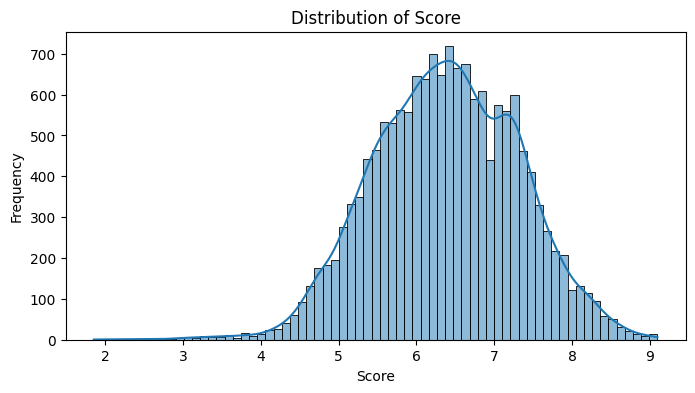

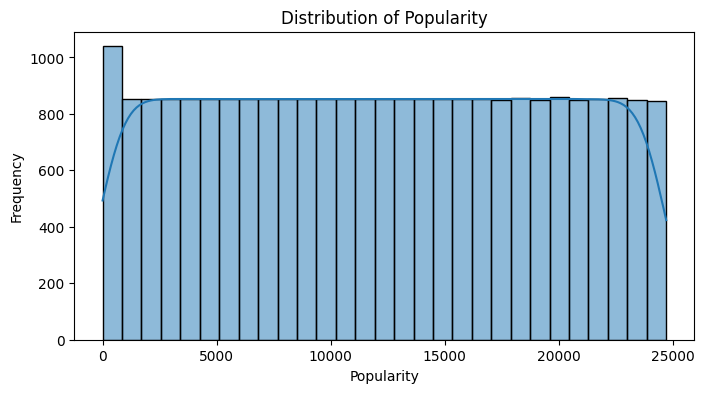

In [52]:
for column in ['Score', 'Popularity']:
    plt.figure(figsize=(8, 4))
    sns.histplot(df[column], kde=True)
    plt.title(f'Distribution of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.show()


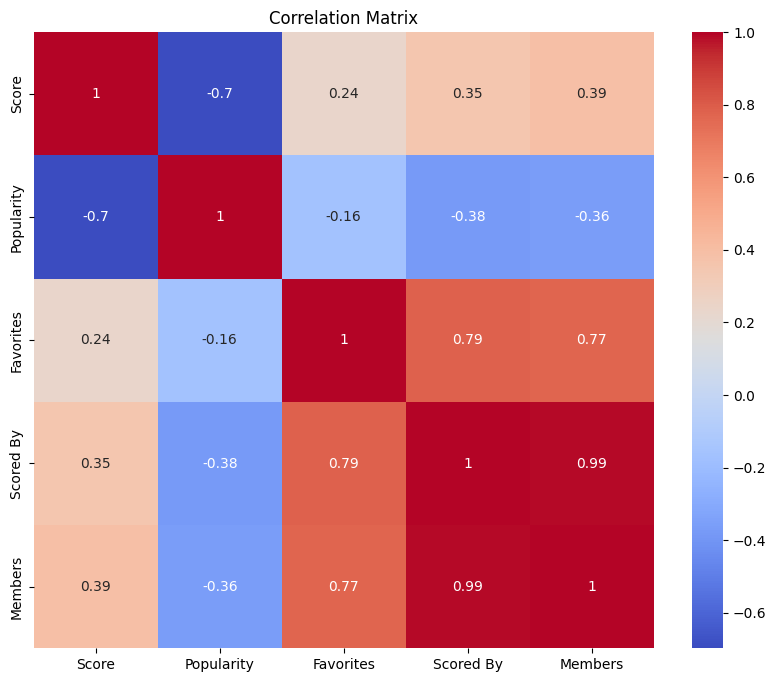

In [53]:
plt.figure(figsize=(10, 8))
sns.heatmap(df[['Score', 'Popularity', 'Favorites', 'Scored By', 'Members']].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

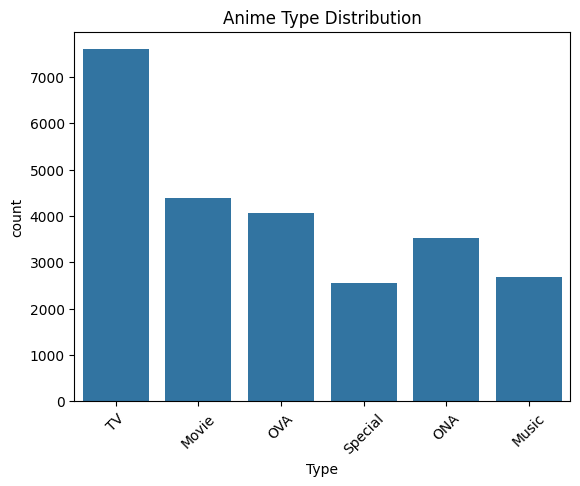

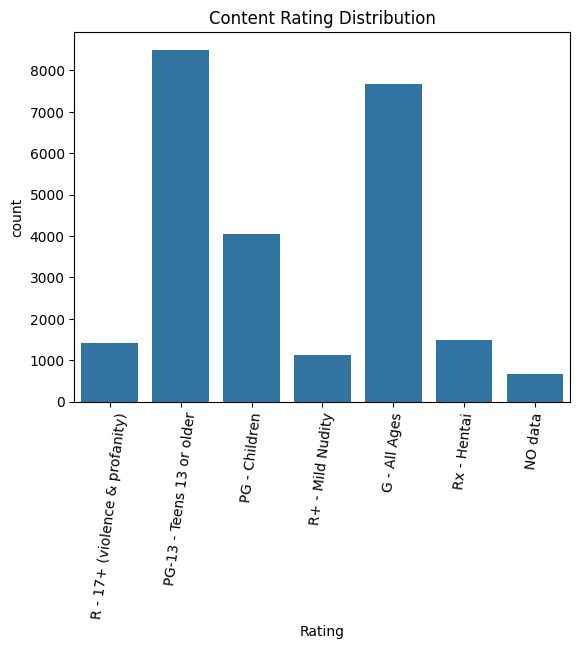

In [54]:
sns.countplot(data=df, x='Type')
plt.title('Anime Type Distribution')
plt.xticks(rotation=45)
plt.show()
sns.countplot(data=df, x='Rating')
plt.title('Content Rating Distribution')
plt.xticks(rotation=83)
plt.show()

In [55]:
df.columns

Index(['anime_id', 'Name', 'English name', 'Score', 'Genres', 'Synopsis',
       'Type', 'Episodes', 'Aired', 'Status', 'Producers', 'Studios', 'Source',
       'Duration', 'Rating', 'Popularity', 'Favorites', 'Scored By', 'Members',
       'Image URL'],
      dtype='object')

# PRE PROCESSING

## Feature Selection

In [56]:
feature_columns = ['anime_id', 'Name', 'English name', 'Score', 'Genres', 'Synopsis',
       'Type', 'Episodes', 'Aired', 'Producers', 'Studios', 'Source',
       'Duration', 'Rating', 'Popularity', 'Favorites', 'Scored By', 'Members',
       'Image URL']

Use only columns that exist in the dataset

In [57]:
available_columns = [col for col in feature_columns if col in df.columns]
animes = df[available_columns].copy()
print(f"Selected features: {animes.columns.tolist()}")

Selected features: ['anime_id', 'Name', 'English name', 'Score', 'Genres', 'Synopsis', 'Type', 'Episodes', 'Aired', 'Producers', 'Studios', 'Source', 'Duration', 'Rating', 'Popularity', 'Favorites', 'Scored By', 'Members', 'Image URL']


## Text Preprocessing

In [58]:
def preprocess_text(text):
    if not isinstance(text, str) or text == "UNKNOWN":
        return ""
    # Convert to lowercase
    text = text.lower()
    # Remove special characters
    text = re.sub(r'[^a-zA-Z0-9\s]', ' ', text)
    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()
    # Tokenize
    words = text.split()
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word not in stop_words]
    # Stemming
    ps = PorterStemmer()
    words = [ps.stem(word) for word in words]
    # Join words back
    return ' '.join(words)

# Apply text preprocessing
print("\n--- Text Preprocessing ---")
text_columns = ['Synopsis', 'Type']
for col in text_columns:
    if col in animes.columns:
        animes[f'processed_{col.lower()}'] = animes[col].astype(str).apply(preprocess_text)

print("Text preprocessing completed")


--- Text Preprocessing ---
Text preprocessing completed


## Vectorization using TF-IDF

In [59]:
tfidf_genres = TfidfVectorizer(tokenizer=lambda x: x.split(', '))
genres_vec = tfidf_genres.fit_transform(animes['Genres'])

tfidf_synopsis = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1, 2),
    sublinear_tf=True
)
synopsis_vec = tfidf_synopsis.fit_transform(animes['processed_synopsis'])


AttributeError: 'NAType' object has no attribute 'lower'

## Normalization and Encoding

In [ ]:
scaler = MinMaxScaler()
normalized = scaler.fit_transform(animes[['Score', 'Popularity', 'Favorites', 'Scored By', 'Members']])
normalized_sparse = csr_matrix(normalized)

encoder = OneHotEncoder(handle_unknown='ignore')
cat_encoded = encoder.fit_transform(animes[['Type']])

## Combine all feature vectors

In [ ]:
final_vectors = hstack([genres_vec, synopsis_vec, cat_encoded, normalized_sparse])
print(f"Final vector shape: {final_vectors.shape}")

Calculate similarity matrix

In [ ]:
similarity = cosine_similarity(final_vectors)
print(f"Similarity matrix shape: {similarity.shape}")

Display Function

In [ ]:
def display_recommendations(recommendations, user_favorites=None):

    if recommendations.empty:
        return

    print("\n========== ANIME RECOMMENDATIONS ==========\n")

    if user_favorites and len(user_favorites) > 0:
        print("Based on your favorites:")
        for i, fav in enumerate(user_favorites, 1):
            print(f"  {i}. {fav}")
        print("")


    for i, (_, row) in enumerate(recommendations.iterrows(), 1):
        print(f"{i}. {row['Name']}")
        print(f"   Genre: {row['Genres']}")
        print(f"   Type: {row['Type']} | Episodes: {row['Episodes']} | Score: {row['Score']:.2f}")
        if 'collab_score' in row:
           print(f"   Collaborative Score: {row['collab_score']:.4f}")
        elif 'similarity_score' in row:
           print(f"   Similarity Score: {row['similarity_score']:.4f}")
        print("-" * 50)

# Content-Based Filtering

In [ ]:
import difflib

def recommend_anime(title, top_n=5, similarity_matrix=similarity, anime_df=animes):
    title = title.lower()

    # Gabungkan pencarian di Name dan English name
    match = anime_df[anime_df['Name'].str.lower() == title]
    if match.empty:
        match = anime_df[anime_df['English name'].str.lower() == title]

    # Jika masih tidak ditemukan, cari yang paling mirip
    if match.empty:
        all_titles = anime_df['Name'].str.lower().tolist()
        closest_matches = difflib.get_close_matches(title, all_titles, n=1)
        if not closest_matches:
            print(f"No anime found with title similar to '{title}'")
            return pd.DataFrame()
        print(f"No exact match found. Using closest match: {closest_matches[0]}")
        match = anime_df[anime_df['Name'].str.lower() == closest_matches[0]]

    idx = match.index[0]

    # Hitung similarity dan ambil top N
    sim_scores = list(enumerate(similarity_matrix[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)[:top_n]
    top_indices = [i[0] for i in sim_scores]

    # Ambil anime rekomendasi
    recommendations = anime_df.iloc[top_indices].copy()
    recommendations['similarity_score'] = [i[1] for i in sim_scores]

    return recommendations[['Name', 'Score', 'Genres', 'Type', 'Episodes', 'similarity_score']]

In [ ]:
CB_recommendations = recommend_anime("Naruto")
display_recommendations(CB_recommendations)

# Multi-Anime Content-Based Filtering

In [ ]:
def collaborative_recommendations(user_favorites=None, top_n=5, similarity_matrix=similarity, anime_df=animes):

    if not user_favorites or len(user_favorites) == 0:
        print("No user favorites provided.")
        return pd.DataFrame()

    # Normalize and index user favorites
    user_favorites = [fav.strip().lower() for fav in user_favorites]
    favorite_indices = []
    for fav in user_favorites:
        match = anime_df[anime_df['Name'].str.lower() == fav]
        if not match.empty:
            favorite_indices.append(match.index[0])

    if not favorite_indices:
        print("None of the favorite titles matched the dataset.")
        return pd.DataFrame()

    # Compute average similarity score across user favorites
    scores = []
    for idx in range(len(anime_df)):
        if idx in favorite_indices:
            continue  # Skip already liked anime
        avg_sim = np.mean([similarity_matrix[idx, fav_idx] for fav_idx in favorite_indices])
        scores.append((idx, avg_sim))

    # Sort by collaborative score
    scores.sort(key=lambda x: x[1], reverse=True)
    top_indices = [i[0] for i in scores[:top_n]]

    # Prepare recommendations
    recommendations = anime_df.iloc[top_indices].copy()
    recommendations['collab_score'] = [i[1] for i in scores[:top_n]]

    # Display columns
    display_columns = ['Name', 'Score', 'Genres', 'Type', 'Episodes', 'collab_score']
    if 'English name' in anime_df.columns:
        display_columns.insert(1, 'English name')
    for col in ['Studios', 'Source', 'Rating', 'Popularity']:
        if col in anime_df.columns:
            display_columns.insert(-1, col)

    return recommendations[display_columns]


In [ ]:
user_favorites = ["Naruto", "Naruto: Shippuuden", "One Piece"]
try:
    recommend = collaborative_recommendations(user_favorites=user_favorites)
    display_recommendations(recommend, user_favorites)
except Exception as e:
    print(f"Error during hybrid recommendation: {e}")

# Item-Based Collaborative Filtering

In [ ]:
popular_anime = ratings['anime_id'].value_counts()[lambda x: x >= 5000].index
filtered_ratings = ratings[ratings['anime_id'].isin(popular_anime)]
user_item_matrix = filtered_ratings.pivot_table(index='user_id', columns='anime_id', values='rating')

In [ ]:
# 3. Hitung similarity antar anime (item-based CF)
# Gantilah NaN dengan 0 agar bisa dihitung similarity
item_similarity = cosine_similarity(user_item_matrix.fillna(0).T)
item_similarity_df = pd.DataFrame(item_similarity, index=user_item_matrix.columns, columns=user_item_matrix.columns)

# 4. Fungsi rekomendasi berdasarkan anime yang disukai user
def recommend_collaborative(user_favorites, top_n=5, anime_df=animes):
    fav_ids = []
    for title in user_favorites:
        match = anime_df[anime_df['Name'].str.lower() == title.lower()]
        if not match.empty:
            fav_ids.append(match.iloc[0]['anime_id'])

    if not fav_ids:
        print("Anime favorit tidak ditemukan.")
        return pd.DataFrame()

    scores = {}
    for anime_id in item_similarity_df.columns:
        if anime_id in fav_ids:
            continue
        # Ambil similarity dari semua fav_ids ke anime ini dan rata-rata
        similarities = [item_similarity_df.loc[fav_id, anime_id] for fav_id in fav_ids if fav_id in item_similarity_df.index and anime_id in item_similarity_df.columns]
        if similarities:
            scores[anime_id] = np.mean(similarities)

    top_recs = sorted(scores.items(), key=lambda x: x[1], reverse=True)[:top_n]
    top_ids = [rec[0] for rec in top_recs]
    top_scores = {rec[0]: rec[1] for rec in top_recs}

    recommendations = anime_df[anime_df['anime_id'].isin(top_ids)].copy()
    recommendations['collab_score'] = recommendations['anime_id'].map(top_scores)

    display_columns = ['Name', 'English name', 'Score', 'Genres', 'Type', 'Episodes', 'collab_score']
    return recommendations[display_columns].sort_values(by='collab_score', ascending=False)


In [ ]:
user_favorites = ["Naruto", "Naruto: Shippuuden", "One Piece"]
recommend = recommend_collaborative(user_favorites=user_favorites)
display_recommendations(recommend, user_favorites)

# **Kesimpulan**

* Dari Content-Based Filtering (CBF) dapat dilihat hasil paling tinggi secara cosine similarity, membuktikan bahwa vektor konten seperti genre, sinopsis, dan skor memberikan dasar kuat untuk relevansi rekomendasi.
* Nilai similarity yang tinggi (hampir 0.85–1.00) menunjukkan sistem dapat menangkap makna konten dengan akurat.
* Sedangkan Multi-Anime CBF sangat berguna bagi pengguna dengan selera campuran, dan tetap menghasilkan skor tinggi, walaupun lebih terdispersi.
* Dan Collaborative Filtering memperluas cakupan dengan variasi yang lebih besar, meski kadang menyimpang dari konten, namun menyajikan rekomendasi berbasis preferensi kolektif.
